# Using the DatasetGradientIMNN
With a generative model built in jax for example we can calculate the derivatives of some simulations with which we can use the chain rule to calculate the derivatives of the network outputs with respect to the physical model parameters necessary to fit an IMNN. Furthermore, if the simulations are too numerous or too large to fit into memory or could be accelerated over several devices, we can aggregate the gradients too. This is an expensive operation and should only be used if memory over a single device is really an issue. Note that with a fixed data set for training an IMNN it is important to have a validation set for early stopping. This is because, with a limited training set there *will* be accidental correlations which look like they are due to parameters and the IMNN *will* extract these features. Using a validation set for early stopping makes sure that once all the features in the validation set have been extracted then no extra information can be incorrectly processed.

For this example we are going to summaries the unknown mean, $\mu$, and variance, $\Sigma$, of $n_{\bf d}=10$ data points of two 1D random Gaussian field, ${\bf d}=\{d_i\sim\mathcal{N}(\mu,\Sigma)|i\in[1, n_{\bf d}]\}$. This is an interesting problem since we know the likelihood analytically, but it is non-Gaussian
$$\mathcal{L}({\bf d}|\mu,\Sigma) = \prod_i^{n_{\bf d}}\frac{1}{\sqrt{2\pi|\Sigma|}}\exp\left[-\frac{1}{2}\frac{(d_i-\mu)^2}{\Sigma}\right]$$

As well as knowing the likelihood for this problem, we also know what sufficient statistics describe the mean and variance of the data - they are the mean and the variance
$$\frac{1}{n_{\bf d}}\sum_i^{n_{\bf d}}d_i = \mu\textrm{  and  }\frac{1}{n_{\bf d}-1}\sum_i^{n_{\bf d}}(d_i-\mu)^2=\Sigma$$
What makes this an interesting problem for the IMNN is the fact that the sufficient statistic for the variance is non-linear, i.e. it is a sum of the square of the data, and so linear methods like MOPED would be lossy in terms of information.

We can calculate the Fisher information by taking the negative second derivative of the likelihood taking the expectation by inserting the relations for the sufficient statistics, i.e. and examining at the fiducial parameter values
$${\bf F}_{\alpha\beta} = -\left.\left(\begin{array}{cc}\displaystyle-\frac{n_{\bf d}}{\Sigma}&0\\0&\displaystyle-\frac{n_{\bf d}}{2\Sigma^2}\end{array}\right)\right|_{\Sigma=\Sigma^{\textrm{fid}}}.$$

Choosing fiducial parameter values of $\mu^\textrm{fid}=0$ and $\Sigma^\textrm{fid}=1$ we find that the determinant of the Fisher information matrix is $|{\bf F}_{\alpha\beta}|=50$.

In [ ]:
from imnn import DatasetGradientIMNN

from imnn.utils import value_and_jacfwd

import jax
import jax.numpy as np
from jax.experimental import stax, optimizers

import tensorflow as tf

We're going to use 1000 summary vectors, with a length of two, at a time to make an estimate of the covariance of network outputs and the derivative of the mean of the network outputs with respect to the two model parameters.

In [2]:
n_s = 1000
n_d = n_s

n_params = 2
n_summaries = n_params

input_shape = (10,)

The simulator is simply

In [3]:
def simulator(key, θ):
    return θ[0] + jax.random.normal(key, shape=input_shape) * np.sqrt(θ[1])

Our fiducial parameter values are $\mu^\textrm{fid}=0$ and $\Sigma^\textrm{fid}=1$. We will vary these values by $\delta\mu=0.1$ and $\delta\Sigma=0.1$.

In [ ]:
θ_fid = np.array([0., 1.])

We will use the CPU as the host device and use the GPUs for calculating the summaries.

In [5]:
host = jax.devices("cpu")[0]
devices = jax.devices("gpu")
n_devices = len(devices)

Now lets say that we know that we can process 100 simulations at a time per device before running out of memory, we therefore can set

In [6]:
n_per_device = 100

For initialising the neural network a random number generator and we'll grab another for generating the data:

In [7]:
rng = jax.random.PRNGKey(10)
rng, model_key, data_key = jax.random.split(rng, num=3)

We can generate the simulations using:

In [8]:
get_sims_and_ders = value_and_jacfwd(simulator, argnums=1)

We'll make the keys for each of the simulations for fitting and validation

In [9]:
data_keys = np.array(jax.random.split(rng, num=2 * n_s))

To best accelerate the aggregation of the gradient calculation the computation is split into two parts, a ``main`` loop which loops through ``n_d`` simulation with its derivative with respect to model parameters, and a ``remaining`` loop of ``n_s - n_d`` iterations, where just simulations are looped through to calculate any other necessary summaries to estimate the covariance. Note this is true even if ``n_s = n_s`` the remaining loop just has zero iterations.

In [10]:
fiducial, derivative = jax.vmap(get_sims_and_ders)(
    data_keys[:n_d], np.repeat(np.expand_dims(θ_fid, 0), n_d, axis=0))

remaining = jax.vmap(simulator)(
    data_keys[n_d:n_s], 
    np.repeat(np.expand_dims(θ_fid, 0), n_s - n_d, axis=0))

validation_fiducial, validation_derivative = jax.vmap(get_sims_and_ders)(
    data_keys[n_s:n_s + n_d], np.repeat(np.expand_dims(θ_fid, 0), n_d, axis=0))

validation_remaining = jax.vmap(simulator)(
    data_keys[n_s + n_d:], 
    np.repeat(np.expand_dims(θ_fid, 0), n_s - n_d, axis=0))

The datasets *must* be made in a very specific way and this is not currently checked. Any failure to build the dataset in exactly the correct way will cause either failures or errors in the results. If data fits in memory then do consider passing the numpy arrays to ``AggregatedGradientIMNN`` which does all necessary checking. For the ``DatasetlGradientIMNN`` we need a list of datasets over each device which output numpy iterators. This means that we need to reshape the data into the correct shape. So to construct the dataset we'll need to set very particular shapes:

In [11]:
batch_shape = (
    n_devices, 
    n_d // (n_devices * n_per_device), 
    n_per_device) + input_shape

remaining_batch_shape = (
    n_devices, 
    (n_s - n_d) // (n_devices * n_per_device), 
    n_per_device) + input_shape

Note that if the reshaping isn't exact then there will be problems, this is avoided if passing directly to ``AggregatedGradientIMNN``, where checking is automatically done. The datasets then must be made using:

In [12]:
main = [
    tf.data.Dataset.from_tensor_slices(
        (fiducial, derivative)).repeat().as_numpy_iterator()
    for fiducial, derivative in zip(
        fiducial.reshape(batch_shape),
        derivative.reshape(batch_shape + (n_params,)))]

remaining = [
    tf.data.Dataset.from_tensor_slices(fiducial
        ).repeat().as_numpy_iterator()
    for fiducial in remaining.reshape(
        remaining_batch_shape)]

validation_main = [
    tf.data.Dataset.from_tensor_slices(
        (fiducial, derivative)).repeat().as_numpy_iterator()
    for fiducial, derivative in zip(
        validation_fiducial.reshape(batch_shape),
        validation_derivative.reshape(batch_shape + (n_params,)))]

validation_remaining = [
    tf.data.Dataset.from_tensor_slices(fiducial
        ).repeat().as_numpy_iterator()
    for fiducial in validation_remaining.reshape(
        remaining_batch_shape)]

Note that if passing a dataset, very flexible data loading can be performed (as long as it is done carefully). For example, if we saved each simulation and each set of derivatives to numpy files using
```python
for i, (fid, val_fid, der, val_der) in enumerate(zip(
        fiducial, validation_fiducial, derivative, validation_derivative)):
    np.save(f"tmp/fiducial_{i:04d}.npy", fid)
    np.save(f"tmp/validation_fiducial_{i:04d}.npy", val_fid)
    np.save(f"tmp/derivative_{i:04d}.npy", der)
    np.save(f"tmp/validation_derivative_{i:04d}.npy", val_der)

for i, (rem, val_rem) in enumerate(zip(
        remaining, validation_remaining)):
    np.save(f"tmp/remaining_{i:04d}.npy", rem)
    np.save(f"tmp/validation_remaining_{i:04d}.npy", val_rem)
```
We could then write the datasets as
```python
def generator(directory, filename, total):
    i = 0
    while i < total:
        yield np.load(f"{directory}/{filename}_{i:04d}.npy")
        i += 1
        
from functools import partial

main = [
    tf.data.Dataset.zip((
         tf.data.Dataset.from_generator(
             partial(
                 generator, 
                 "tmp", 
                 "fiducial", 
                 n_d), 
             tf.float32),
        tf.data.Dataset.from_generator(
             partial(
                 generator, 
                 "tmp", 
                 "derivative", 
                 n_d), 
             tf.float32))
        ).take(n_d // n_devices
        ).batch(n_per_device
        ).repeat(
        ).as_numpy_iterator()
    for _ in range(n_devices)]

remaining = [
    tf.data.Dataset.from_generator(
        partial(
            generator, 
            "tmp", 
            "remaining", 
            n_s - n_d), 
        tf.float32
        ).take((n_s - n_d) // n_devices
        ).batch(n_per_device
        ).repeat(
        ).as_numpy_iterator()
    for _ in range(n_devices)]

validation_main = [
    tf.data.Dataset.zip((
         tf.data.Dataset.from_generator(
             partial(
                 generator, 
                 "tmp", 
                 "validation_fiducial", 
                 n_d), 
             tf.float32),
        tf.data.Dataset.from_generator(
             partial(
                 generator, 
                 "tmp", 
                 "validation_derivative", 
                 n_d), 
             tf.float32))
        ).take(n_d // n_devices
        ).batch(n_per_device
        ).repeat(
        ).as_numpy_iterator()
    for _ in range(n_devices)]

validation_remaining = [
    tf.data.Dataset.from_generator(
        partial(
            generator, 
            "tmp", 
            "validation_remaining", 
            n_s - n_d), 
        tf.float32
        ).take((n_s - n_d) // n_devices
        ).batch(n_per_device
        ).repeat(
        ).as_numpy_iterator()
    for _ in range(n_devices)]
```
Of course we can add ``tf.data.Dataset`` functions like ``prefetch`` and ``cache`` if we want too, i.e. 
```python
main = [
    tf.data.Dataset.zip((
         tf.data.Dataset.from_generator(
             partial(
                 generator, 
                 "tmp", 
                 "fiducial"), 
             tf.float32),
        tf.data.Dataset.from_generator(
             partial(
                 generator, 
                 "tmp", 
                 "derivative"), 
             tf.float32))
        ).take(n_d // n_devices
        ).batch(n_per_device
        ).cache(
        ).prefetch(tf.data.AUTOTUNE
        ).repeat(
        ).as_numpy_iterator()
    for _ in range(n_devices)]
```
etc.

This loading will be quite slow because the files need to be opened each time, but we can build TFRecords which are quicker to load. There is a writer able to do the correct format. The TFRecords should be a couple hundred Mb for best flow-through, so we can keep filling the record until this size is reached.

```python
from imnn import TFRecords

record_size = 200 #Mb
writer = TFRecords(record_size=record_size)
```

We need a function which grabs single simulations from an array (or file) to add to the record

```python
def get_simulation(seed, directory=None, filename=None):
    return np.load(f"{directory}/{filename}_{seed:04d}.npy")

writer.write_record(
    n_sims=n_d,
    get_simulation=lambda seed: get_simulation(
        seed, directory="tmp", filename="fiducial"),
    directory="tmp",
    filename="fiducial")

writer.write_record(
    n_sims=n_s - n_d,
    get_simulation=lambda seed: get_simulation(
        seed, directory="tmp", filename="remaining"),
    directory="tmp",
    filename="remaining")

writer.write_record(
    n_sims=n_d,
    get_simulation=lambda seed: get_simulation(
        seed, directory="tmp", filename="derivative"),
    directory="tmp",
    filename="derivative")

writer.write_record(
    n_sims=n_d,
    get_simulation=lambda seed: get_simulation(
        seed, directory="tmp", filename="validation_fiducial"),
    directory="tmp",
    filename="validation_fiducial")

writer.write_record(
    n_sims=n_s - n_d,
    get_simulation=lambda seed: get_simulation(
        seed, directory="tmp", filename="validation_remaining"),
    directory="tmp",
    filename="validation_remaining")

writer.write_record(
    n_sims=n_d,
    get_simulation=lambda seed: get_simulation(
        seed, directory="tmp", filename="validation_derivative"),
    directory="tmp",
    filename="validation_derivative")
```

We can then read these to a dataset using (note the parser from the TFRecords class):

```python
import glob
        
main = [
    tf.data.Dataset.zip((
        tf.data.TFRecordDataset(
            sorted(glob.glob("tmp/fiducial_*.tfrecords")),
            num_parallel_reads=1).map(writer.parser),
        tf.data.TFRecordDataset(
            sorted(glob.glob("tmp/derivative_*.tfrecords")),
            num_parallel_reads=1).map(
                lambda example: writer.derivative_parser(
                    example, n_params=n_params)))
        ).take(n_d // n_devices
        ).batch(n_per_device
        ).repeat(
        ).as_numpy_iterator()
    for _ in range(n_devices)]

remaining = [
    tf.data.TFRecordDataset(
            sorted(glob.glob("tmp/remaining_*.tfrecords")),
            num_parallel_reads=1).map(writer.parser
        ).take((n_s - n_d) // n_devices
        ).batch(n_per_device
        ).repeat(
        ).as_numpy_iterator()
    for _ in range(n_devices)]

validation_main = [
    tf.data.Dataset.zip((
        tf.data.TFRecordDataset(
            sorted(glob.glob("tmp/validation_fiducial_*.tfrecords")),
            num_parallel_reads=1).map(writer.parser),
        tf.data.TFRecordDataset(
            sorted(glob.glob("tmp/validation_derivative_*.tfrecords")),
            num_parallel_reads=1).map(
                lambda example: writer.derivative_parser(
                    example, n_params=n_params)))
        ).take(n_d // n_devices
        ).batch(n_per_device
        ).repeat(
        ).as_numpy_iterator()
    for _ in range(n_devices)]

validation_remaining = [
    tf.data.TFRecordDataset(
            sorted(glob.glob("tmp/validation_remaining_*.tfrecords")),
            num_parallel_reads=1).map(writer.parser
        ).take((n_s - n_d) // n_devices
        ).batch(n_per_device
        ).repeat(
        ).as_numpy_iterator()
    for _ in range(n_devices)]

```

We're going to use ``jax``'s stax module to build a simple network with three hidden layers each with 128 neurons and which are activated by leaky relu before outputting the two summaries. The optimiser will be a ``jax`` Adam optimiser with a step size of 0.001.

In [13]:
model = stax.serial(
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(128),
    stax.LeakyRelu,
    stax.Dense(n_summaries))
optimiser = optimizers.adam(step_size=1e-3)

The DatasetGradientIMNN can now be initialised setting up the network and the fitting routine (as well as the plotting function)

In [14]:
imnn = DatasetGradientIMNN(
    n_s=n_s, n_d=n_d, n_params=n_params, n_summaries=n_summaries, 
    input_shape=input_shape, θ_fid=θ_fid, model=model, 
    optimiser=optimiser, key_or_state=model_key, host=host,
    devices=devices, n_per_device=n_per_device,
    main=main, remaining=remaining, validation_main=validation_main, 
    validation_remaining=validation_remaining)

To set the scale of the regularisation we use a coupling strength $\lambda$ whose value should mean that the determinant of the difference between the covariance of network outputs and the identity matrix is larger than the expected initial value of the determinant of the Fisher information matrix from the network. How close to the identity matrix the covariance should be is set by $\epsilon$. These parameters should not be very important, but they will help with convergence time.

In [15]:
λ = 10.
ϵ = 0.1

Fitting can then be done simply by calling:

In [16]:
imnn.fit(λ, ϵ, patience=10, max_iterations=1000, print_rate=1)

Here we have included a ``print_rate`` for a progress bar, but leaving this out will massively reduce fitting time (at the expense of not knowing how many iterations have been run). The IMNN will be fit for a maximum of ``max_iterations = 1000`` iterations, but with early stopping which can turn on after ``min_iterations = 100`` iterations and after ``patience = 10`` iterations where the maximum determinant of the Fisher information matrix has not increased. ``imnn.w`` is set to the values of the network parameters which obtained the highest value of the determinant of the Fisher information matrix, but the values at the final iteration can be set using ``best = False``.

To continue training one can simply rerun fit

```python
imnn.fit(λ, ϵ, patience=10, max_iterations=1000, print_rate=1)
```
although we will not run it in this example.

To visualise the fitting history we can plot the results:

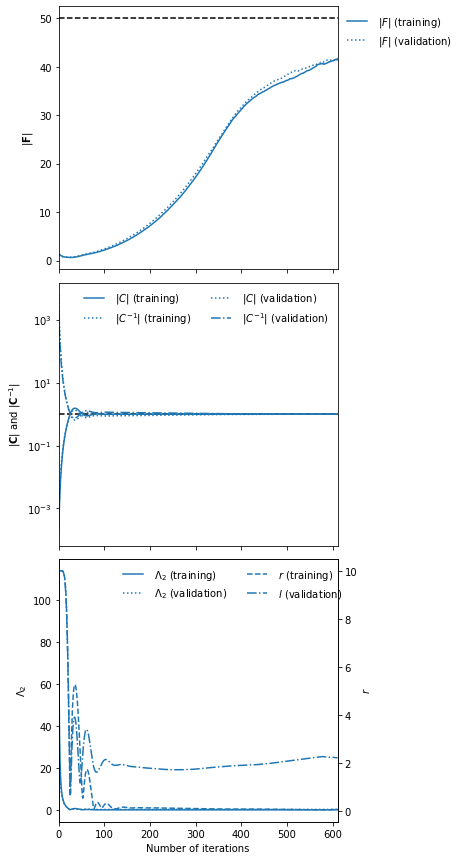

In [17]:
imnn.plot(expected_detF=50);